# Classification

Classification is supervised learning with categorical labels. You are given labeled data consisting of features and labels $\{\vec{x}_i, \vec{y}_i\}$, where $\vec{y}_i$ is a vector of binary values indicating class membership. An example of $\vec{y}_i$ that indicates membership of classes "soluble in THF", "insoluble in water", "soluble in chloroform" might be:

|  THF  | water | chloroform |
|:------|:-----:| ----------:|
|   1   |   0   |   1        |

where we've indicated that the molecule in soluble in THF and chloroform but not water. As a vector, it is $\vec{y} = (1, 0, 1) $.  This is the general format of classification and can be called **multi-label** classification because we are attaching three labels: THF soluble, water insoluble, chloroform soluble. This can be restricted so that each data point belongs to only one class -- called **multi-class** classification. This might be like assigning visible color. A molecule can only be red or green or orange, but not multiple colors. Finally, you can only have one class and a label can only belong to the single class or does not belong to the single class. This is called **binary** classification and is the most common classification type. If you're doing multi-label or multi-class classification, the shape of $\vec{y}$ will be a vector length $K$ where $K$ indicates number of classes. In the case of binary classification, the label is a binary value of 1 or 0 where 1 means it is a member of the class. You can view this as there being two classes: a **positive** class ($y = 1$) and **negative** class ($y = 0$). For example, you could be predicting if a molecule will kill cells. If the molecule is in the positive class, it kills cells. If it is the negative class, it is inert and does not kill cells. Depending on your choice of model type, when you predict the labels ($\hat{\vec{y}}$), your model could predict probabilities. 

```{margin}
Note that in multi-class and binary classification $\sum \hat{\vec{y}} = 1$, but 
in multi-label classification this is not the case. Multi-label classification is like doing $K$ instances of binary classification. 
```

The goal of classification to find a function that describes relationship between features and class, $\hat{f}(\vec{x}) = \hat{y}$. We'll see that this problem can be converted to regression by using probability or *distance from decision boundary*. This means much of what we learned previously can be applied to this problem.

The classic application of classification is designing new drugs, but it's widely used in materials and chemistry. Many molecular design problems can be formulated as classification. For example, you can use it to design new organic photovoltaic materials {cite}`sun2019machine` or antimicrobial peptides {cite}`barrett2018classifying`.

## Data

The dataset for this lecture was prepared by the MoleculeNet group {cite}`wu2018moleculenet`.  It is a collection of molecules that succeeded or failed in clinical trials. The development of a new drug can cost well over a $1 billion, so any way to predict if a molecule will fail duing clinical trials is highly valuable. The reason molecules fail in clinical trials is often due to safety, so even though some of these drugs failed because they were not effective there may be something common to each of the failed ones that we can learn.

The labels will be the FDA_Approved column which is a 1 or 0 indicating FDA approval status. This is an example of binary classification.

## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages, either on your own environment or on Google Colab. We have a new package for this chapter, which can be installed with `pip install mordred[full]`. The complete instructions are:

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell

!pip install jupyter-book matplotlib numpy jaxlib jax pandas seaborn tabulate sklearn mordred[full] rdkit-pypi
```

````

The hidden cell below does our imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import jax.numpy as jnp
import mordred, mordred.descriptors
import jax.experimental.optimizers as optimizers
import jax
import warnings
from zipfile import ZipFile
warnings.filterwarnings('ignore')
IPythonConsole.ipython_useSVG = True
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)

Now we load the data. This is a little fancy because we're extracting the data file from a zip archive on a website. 

In [2]:
from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen
# from web version
#url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz'
#file = urlopen(url).read()
#file = BytesIO(file)
#document = ZipFile(file)
#toxdata = pd.read_csv(document.open('clintox.csv'))
# local version
toxdata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/clintox.csv.gz')
toxdata.head()

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


## Molecular Descriptors

This time, our data does not come with pre-computed descriptors. We only have the SMILES string, which is a way of writing a molecule using letters and numbers (a string). We can use rdkit to convert the SMILES string into a molecule and then we can use a package called Mordred {cite}`moriwaki2018mordred` to compute a set of descriptors for each molecule. This package will compute around 1500 descriptors for each molecule. 

We'll start by converting our molecules into rdkit objects and building a calculator to compute the descriptors.

RDKit ERROR: [16:29:12] Explicit valence for atom # 0 N, 5, is greater than permitted
RDKit ERROR: [16:29:12] Can't kekulize mol.  Unkekulized atoms: 9
RDKit ERROR: 
RDKit ERROR: [16:29:12] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [16:29:12] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [16:29:12] Can't kekulize mol.  Unkekulized atoms: 4
RDKit ERROR: 
RDKit ERROR: [16:29:12] Can't kekulize mol.  Unkekulized atoms: 4
RDKit ERROR: 


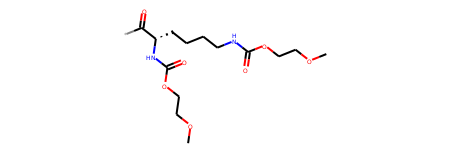

In [3]:

# make object that can compute descriptors
calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in toxdata.smiles]

# view one molecule to make sure things look good.
molecules[0]

Some of our molecules failed to be converted. We'll have to remove them. We need to remember which ones were deleted too, since we need to remove the failed molecules from the labels.

In [4]:
# the invalid molecules were None, so we'll just
# use the fact the None is False in Python
valid_mol_idx = [bool(m) for m in molecules]
valid_mols = [m for m in molecules if m]

In [5]:
features = calc.pandas(valid_mols)

100%|██████████| 1478/1478 [02:44<00:00,  8.97it/s]


Now we just need to stich everything back together so that our labels are consistent and standardize our features. 

In [6]:
labels = toxdata[valid_mol_idx].FDA_APPROVED
features -= features.mean()
features /= features.std()

# we have some nans in features, likely because std was 0
features.dropna(inplace=True, axis=1)

print(f'We have {len(features.columns)} features per molecule')

We have 483 features per molecule


## Classification Models

### Linear Perceptron

We are able to predict singles values from regression. How can we go from a predicted value to a class? The simplest answer is to take our out from $\hat{f}(\vec{x})$ and assign $\hat{y} = 1$ when $\hat{f}(\vec{x}) > 0$,  $\hat{y} = 0$ otherwise. Our model equation is then:

\begin{equation}
\hat{f}(\vec{x}) = \begin{cases} 
      1 & \vec{w}\cdot \vec{x} + b \geq 0 \\
      0 & \textrm{otherwise}\\
   \end{cases}
\end{equation}

The term $\vec{w}\cdot \vec{x} + b$ is called **distance from the decision boundary** where the decision boundary is at $\vec{w}\cdot \vec{x} + b = 0$. If it is large, we are far away from classifying it as 0. If it is small, we are close to classifying it as 0. It can be loosely thought of as "confidence". 

In [7]:
def perceptron(x, w, b):
    v = jnp.dot(x, w) + b
    y = jnp.where(v > 0, x = jnp.zeros_like(v), y = jnp.ones_like(v))
    return y

This particular model is called a **perceptron** and is the first neural network for classification. It was invented in 1958 by Frank Rosenblatt, a psychologist at Cornell University. It was not the first neural network, but is often the first one that students learn. The perceptron is an example of a **hard** classifier; it does not predict probability of the class and instead predicts exactly one class. 


Now that we have a model, we must choose a loss function. We haven't learned about many loss functions yet. We've only seen mean squared error. Let us begin with a related loss called mean absolute error (MAE). MAE measures disagreement between our class and the predicted class. This is like an accuracy -- what percentage of the time we're correct.

\begin{equation}
    L = \frac{1}{N} \sum_i  \left|y_i - \hat{y}_i\right|
\end{equation}

In [8]:
def loss(y, yhat):
    return jnp.mean(jnp.abs(y - yhat))
def loss_wrapper(w, b, x, y):
    yhat = perceptron(x, w, b)
    return loss(y, yhat)
loss_grad = jax.grad(loss_wrapper, (0,1))

In [9]:
batch_size = 32
train_N = int(len(labels) * 0.8)
N = len(labels)
batch_idx = range(0, train_N, batch_size)
w = np.random.normal(size=len(features.columns))
b = 0.

test_x = features[train_N:].values.astype(np.float32)
test_y = labels[train_N:].values

Let's now try out our gradient to make sure it works

In [10]:
loss_grad(w,b, test_x, test_y)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

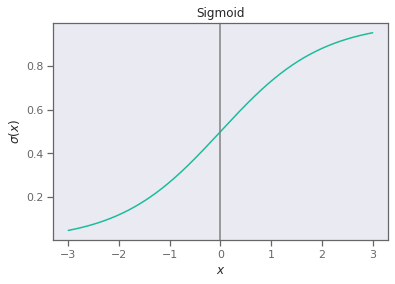

In [11]:
from myst_nb import glue

x = np.linspace(-3, 3, 500)
y = 1 / (1 + np.exp(-x))
plt.plot(x,y)
plt.xlabel(r'$x$')
plt.ylabel(r'$\sigma(x)$')
plt.axvline(0, color='gray')
plt.title('Sigmoid')
glue('sigmoid', plt.gcf(), display=False)

It's all zeros! Why is that? It's because our {ojb}`jnp.where<jax.numpy.where>` statement above is not differentiable, nor are any inequalities where the result is a constant (`1` or `0` in our case). The perceptron actually has a special training procedure that is not related to its derivatives. One of the motivating reasons that deep learning is popular is that we do not need to construct a special training process for each model we construct -- like the training procedure for the perceptron. 

Rather than teach and discuss the special perceptron training procedure, we'll move to a more modern related classifier called a softmax binary classifier. This is a tiny change, the softmax binary classifier is:

\begin{equation}
\hat{f}(\vec{x}) = \sigma\left(\vec{w}\cdot \vec{x} + b\right)
\end{equation}

```{glue:figure} sigmoid
----
name: simgoid
----
The sigmoid function. Input is any real number and the output is a probability. Positive numbers map to probabilities greater than 0.5 and negative numbers to probabilities less than 0.5. 
```

```{margin}
Softmax is the generalization of sigmoid to multiple classes. Although we call our binary classifier a softmax classifier, it doesn't use the softmax function.
```

where $\sigma$ is the **sigmoid** function. The sigmoid has a domain of $(-\infty, \infty)$ and outputs a probability $(0, 1)$. The input to the sigmoid can be viewed as log-odds, called **logits** for short. Odds are ratios of probability -- odds of 1 means the probability of the class 1 is 0.5 and class 0 is 0.5. Odds of 2 means the probability of class 1 is 0.67 and class 0 is 0.33. Log-odds is the natural logarithm of that, so that log-odds of 0 means the odds are 1 and the output probability should be 0.5. One definition of the sigmoid is 

\begin{equation}
\sigma(x) = \frac{1}{1 + e^{-x}}
\end{equation}

however in practice there are some complexities to implementing sigmoids to make sure they're numerically stable. This type of binary classifier is sometimes called **logistic regression** because we're regressing logits. 

In essence, all we've done is replace the inequality of the perceptron with a smooth differentiable version. Just like previously, a positive number indicated class 1 (FDA approved) but now it's a continuum of numbers from 0.5 to 1.0. This is **soft** classification -- we give probabilities of class membership instead of hard assignment. However, our loss function now needs to be modified as well. 

There is a different loss function that works better with classification called **cross-entropy**. You can experiment with mean absolute error or mean squared error with classification, but you'll find they are almost always worse than cross-entropy.

Cross-entropy is a loss function that describes distance between two probability distributions. When minimized, the two probability distributions are identical. Cross-entropy is a simplification of the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) which is a way to measure distance between two probability distributions. Technically it is not a distance since it's not symmetric with respect to its arguments. But in practice it is close enough to a distance that we treat it as one. 

How is comparing predicted values $\hat{y}$ and $y$ like comparing two probability distributions? Even though these are both 1s and 0s in the case of hard classification, they do sum to 1 and so we consider them probability distributions. Cross-entropy is defined as:

\begin{equation}
    L = -\sum_c^K y_c \log \hat{y_c}
\end{equation}

where $c$ indicates which class of the $K$ we're considering and it's assumed that $\sum_c^K y_c = 1$ and $\sum_c^K \hat{y}_c = 1$ like probabilities (and they are positive). In the case of binary classification (only two classes), this becomes:

\begin{equation}
    L = -\left[ y_0 \log \hat{y_0} + y_1 \log \hat{y_1} \right]
\end{equation}

where $y_0$ is for the first class and $y_1$ is for the second class. However, we also know that because these are probabilities that $y_1 = 1 - y_0$. We can rewrite to:

\begin{equation}
    L = -\left[ y_0 \log \hat{y_0} + (1 - y_0) \log ( 1- \hat{y_0}) \right]
\end{equation}

Finally we can drop the indication of the class:

\begin{equation}
    L = -\left[ y \log \hat{y} + (1 - y) \log ( 1- \hat{y}) \right]
\end{equation}


```{margin}
The correct way to avoid numerical instability in cross-entropy sigmoid classification is to have your model output the logits and you use a loss function that works on logits instead of probability. For example, {obj}`tf.nn.sigmoid_cross_entropy_with_logits`.
```
and this matches our data, where we have a single value for each label indicating if it is a class member. Now we have features, labels, loss, and a model. Let's create a batched gradient descent algorithm to train our classifier. Note, one change we need to do is use the built-in jax {obj}`jax.nn.sigmoid` function to avoid numerical instabilities and also add a small number to all logs to avoid numerical instabilities.

In [12]:
def bin_classifier(x, w, b):
    v = jnp.dot(x, w) + b
    y = jax.nn.sigmoid(v)
    return y
def cross_ent(y, yhat):
    return jnp.mean(-(y * jnp.log(yhat + 1e-10) + (1 - y) * jnp.log(1 - yhat + 1e-10)))
def loss_wrapper(w, b, x, y):
    yhat = bin_classifier(x, w, b)
    return cross_ent(y, yhat)
loss_grad = jax.grad(loss_wrapper, (0,1))
w = np.random.normal(scale=0.01, size=len(features.columns))
b = 1.

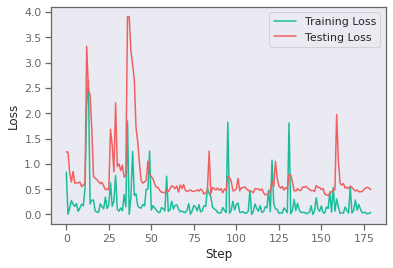

In [13]:
loss_progress = []
test_loss_progress = []
eta = 0.2
for epoch in range(5):
    for i in range(len(batch_idx) - 1):
        x = features[batch_idx[i]:batch_idx[i + 1]].values.astype(np.float32)
        y = labels[batch_idx[i]:batch_idx[i + 1]].values
        grad = loss_grad(w, b, x, y)
        w -= eta * grad[0]
        b -= eta * grad[1]
        loss_progress.append(loss_wrapper(w, b, x, y))
        test_loss_progress.append(loss_wrapper(w, b, test_x, test_y))
plt.plot(loss_progress, label='Training Loss')
plt.plot(test_loss_progress, label='Testing Loss')

plt.xlabel('Step')
plt.legend()
plt.ylabel('Loss')
plt.show()

We are making good progress with our classifier, as judged from testing loss. You can run the code, longer but I'll leave it at that. We have a reasonably well-trained model.

## Classification Metrics

In regression, we assessed model performance with a parity plot, correlation coefficient, or mean squared error. In classification, we use slightly different metrics. The first metric is **accuracy**. Accuracy is the percentage of time that the predicted label matches the true label. We do not have a hard classifier, so we have to choose how to turn probability into a specific class. For now, we will choose the class with the highest probability. Let's see how this looks

In [14]:
def accuracy(y, yhat):
    # convert from prob to hard class
    hard_yhat = np.where(yhat > 0.5, np.ones_like(yhat), np.zeros_like(yhat))
    disagree = np.sum(np.abs(y - yhat))
    return 1 - disagree / len(y)
accuracy(test_y, bin_classifier(test_x, w, b))

0.8269480627936285

In [15]:
glue('acc', accuracy(test_y, bin_classifier(test_x, w, b)))

0.8269480627936285

An accuracy of {glue:text}`acc:.2f` seems quite reasonable! However, consider this model:

In [16]:
def alt_classifier(x):
    return np.ones((x.shape[0]))
accuracy(test_y, alt_classifier(test_x))

0.9087837837837838

This model, which always returns 1, has better accuracy than our model. How is this possible? 

```{admonition} Answer
:class: tip, dropdown
If you examine the data, you'll see the majority of the molecules passed FDA clinical trials ($y = 1$), so that just guessing $1$ is a good strategy.
```

### Error Types

Let's recall what we're trying to do. We're trying to predict if a molecule will make it through FDA clinical trials. Our model can be incorrect in two ways: it predicts a molecule will pass through clinical trials, but it actually fails. This is called a false positive. The other error is if we predict our drug will not make it through clinical trials, but it actually does. This is false negative.

```{margin}
False positive are sometimes known as Type I (pronounced type one) and false negatives as Type II false negatives
```

Our `alt_classifier` model, which simply reports everything as positive, has no false negative errors. It has many false positive errors. These two types of errors can be quantified. We're going to add one complexity -- **threshold**. Our model provides probabilities which we're converting into hard class memberships -- 1s and 0s. We have been choosing to just take the most probable class. However, we will now instead choose a threshold for when we report a positive (class 1). The rationale is that although we train our model to minimize cross-entropy, we may want to be more conservative or aggressive in our classification with the trained model. If we want to minimize false negatives, we can lower the threshold and report even predictions that have a probability of 30% as positive. Or, if we want to minimize false positives we may set our threshold so that our model must predict above 90% before we predict a postive.

In [17]:
def error_types(y, yhat, threshold):
    hard_yhat = np.where(yhat >= threshold, np.ones_like(yhat), np.zeros_like(yhat))
    # predicted 1, actually was 0 -> 1 (bool to remove predicted 0, actually was 1)    
    fp = np.sum((hard_yhat - y) > 0)
    # predicted 0, actually was 1 -> 1 (bool to remove predicted 1, actually was 0)
    fn = np.sum((y - hard_yhat) > 0)
    return fp, fn

In [18]:
print('Alt Classifier', error_types(test_y, alt_classifier(test_x), 0.5))
print('Trained Classifier', error_types(test_y, bin_classifier(test_x, w, b), 0.5))

Alt Classifier (27, 0)
Trained Classifier (20, 20)


Now we have a better sense of how our model does in comparison. The number of errors is indeed larger for our trained model, but it has a bit of balance between the two errors. What is more important? In our case, I would argue doing clinical trials that fail is worse than mistakenly not starting them. That is, false positives are worse than fale negatives. Let's see if we can tune our threshold value to minimize false positives. 

In [19]:
print('Threshold 0.7', error_types(test_y, bin_classifier(test_x, w, b), 0.7))
print('Threshold 0.9', error_types(test_y, bin_classifier(test_x, w, b), 0.9))
print('Threshold 0.95', error_types(test_y, bin_classifier(test_x, w, b), 0.95))
print('Threshold 0.99', error_types(test_y, bin_classifier(test_x, w, b), 0.99))


Threshold 0.7 (18, 26)
Threshold 0.9 (9, 82)
Threshold 0.95 (6, 120)
Threshold 0.99 (1, 218)


By adjusting the threshold, we can achieve a balance of error more like what we desire for our model. We're able to have 1 false positives in fact, at the cost of missing 218 of the molecules. Now are we still predicting positives? Are we actually going to get some **true positives?** We can measure that as well

In [20]:
total_pos = np.sum(test_y)
print('Total positives:', total_pos, 'Predicted Positives:', np.sum(bin_classifier(test_x, w, b) > 0.99))

Total positives: 269 Predicted Positives: 52


Yes, our model is actually capable of predicting molecules will pass FDA clinical trials with as few false positives as possible (0). A model that is capable of this tuning is an example of a good model. Our other model, that predicts 1s, has good accuracy but we cannot adjust it or try to better balance type I and type II errors. 

### Receiver-Operating Characteristic Curve

We can plot threshold, false positive rate, and true positive rate all together on one plot to capture model accuracy and balance between error type in a Receiver-Operating Characteristic Curve (ROC curve). The x-axis of ROC curve is false positive rate and y-axis is true positive rate. Each point on the plot is our model with a different threshold. How do we choose which thresholds to use? Well it's just the number of unique class probabilities we saw. We do need to add two extremes: all positive and all negative.  So for example, our alt model will only have one point on this curve. Let's make one and discuss what we're seeing.

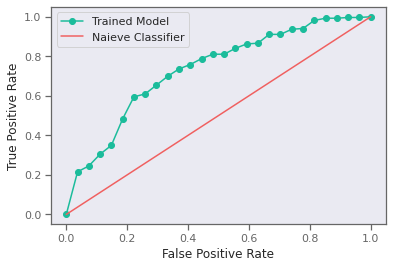

In [21]:
unique_threshes = np.unique(bin_classifier(test_x, w, b))
fp = []
tp = []
total_pos = np.sum(test_y)
for ut in list(unique_threshes) + [-0.1, 1.01]:
    errors = error_types(test_y, bin_classifier(test_x, w, b), ut)
    fp.append(errors[0])
    tp.append(total_pos - errors[1])

# sort them so can plot as a line
idx = np.argsort(fp) 
fpr = np.array(fp)[idx]  / (len(test_y) - np.sum(test_y))
tpr = np.array(tp)[idx] / np.sum(test_y)

# now remove duplicate x-values
fpr_nd = []
tpr_nd = []
last = None
for f,t in zip(fpr, tpr):
    if last is None or f != last:
        last = f
        fpr_nd.append(f)
        tpr_nd.append(t)

plt.plot(fpr_nd, tpr_nd, '-o', label='Trained Model')
plt.plot([0,1], [0, 1], label='Naieve Classifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

This plot nicely shows how our trained model is actually sensitive to threshold, so that we could choose to more carefully screen for false negative or false positives. The best curves fall to the top-left of this plot. Our naieve classifier is where we return a fixed percentage of examples randomly as positive or negative. You can plot the area under this curve with an integration and this is a good way to measure classifier performance and correctly capture the effect of both false negatives and false positives. 

### Other metrics

I will just mention that there are other ways to assess how your model balances the two error types. One major type is called **precision** and **recall**. Precision measures correctness of predicted positives and recall measures number of predicted positives. This can be a good viewpoint when doing molecular screening -- you may want to be very precise in that your proposed molecules are accurate while sacrificing recall. Recall here meaning you do not return very many molecules. Models on the left of an ROC curve are precise. Models at the top have good recall.  There are also F1 scores, likelihoods, and Matthew's correlation coefficient which all try to report one number which balances precision and recall.. We will rarely explore these other measures but you should know they exist. 


## Class Imbalance

The reason for this uneven amount of false positives and false negatives is that we have very few negative example -- molecules which failed FDA clinical trials. This also explains why just predicting success has a high accuracy. How can we address this problem?

The first answer is: is this a problem at all? Perhaps a drug in general will succeed at clinical trials and thus the imbalance in training data reflects what we expect to see in testing. This is clearly not the case, judging from the difficult and large expense of creating new drug molecules. However, this should be the first thing you ask yourself. If you're creating a classifier to detect lung cancer from X-ray images, probably you will have imbalanced training data and at test time, when evaluating patients, you'll also not have 50% of patients having lung cancer. This comes back to the discussion in the [previous chapter](content:training-tata-distribution) about training data distribution. If you're testing data is within your training data distribution, then the class imbalance does not need to be explicitly addressed.

The second solution is to somehow weight your training data to appear more like your testing data when you think you do have **label shift**. There are two ways to accomplish this. You could "augment" your training data by repeating the minority class until the ratio of minority to majority examples matches the assumed testing data. There are research papers written on this topic, with intuitive results{cite}`chawla2002smote`. You can over-sample minority class but that can lead to a large dataset, so you can also under-sample the majority class. This is a robust approach that is independent to how you train.

Another method of weighing data is to modify your loss function to increase the gradient updates applied to minority examples. This is equivalent to saying there is a difference in loss between a false positive vs a false negative. In our case, false positive are rarer and also more important in reality. We already tried minimizing false positives by changing the threshold on a trained model but let's see how this works during training. We'll create a weight vector that is high for negative labels so that if they are misclassified (false positive), there will be a bigger update.


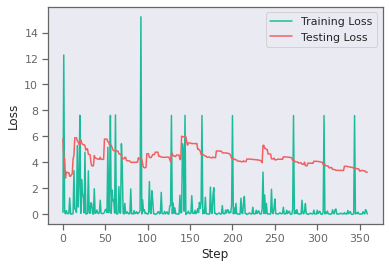

Normal Classifier (20, 20)
Weighted Classifier (6, 119)


In [22]:
def bin_classifier(x, w, b):
    v = jnp.dot(x, w) + b
    y = jax.nn.sigmoid(v)
    return y
def weighted_cross_ent(y, yhat, yw):
    # weights may not be normalized
    N = jnp.sum(yw)
    # use weighted sum instead    
    return jnp.sum(-(yw * y * jnp.log(yhat + 1e-10) + yw * (1 - y) * jnp.log(1 - yhat + 1e-10))) / N
def loss_wrapper(w, b, x, y, yw):    
    yhat = bin_classifier(x, w, b)
    return weighted_cross_ent(y, yhat, yw)
loss_grad = jax.grad(loss_wrapper, (0,1))
w2 = np.random.normal(scale=0.01, size=len(features.columns))
b2 = 1.
weights = np.ones_like(labels)
# make the labels = 0 values be much larger
weights[labels.values == 0] *= 1000
# now make weights be on average 1
# to keep our learning rate/avg update consistent
weights = weights * len(weights) / np.sum(weights)

loss_progress = []
test_loss_progress = []
eta = 0.2
# make epochs larger since this has
# very large steps that converge poorly
for epoch in range(10):
    for i in range(len(batch_idx) - 1):
        x = features[batch_idx[i]:batch_idx[i + 1]].values.astype(np.float32)
        y = labels[batch_idx[i]:batch_idx[i + 1]].values
        yw = weights[batch_idx[i]:batch_idx[i + 1]]        
        grad = loss_grad(w2, b2, x, y, yw)
        w2 -= eta * grad[0]
        b2 -= eta * grad[1]
        loss_progress.append(loss_wrapper(w2, b2, x, y, yw))
        test_loss_progress.append(loss_wrapper(w2, b2, test_x, test_y, np.ones_like(test_y)))
plt.plot(loss_progress, label='Training Loss')
plt.plot(test_loss_progress, label='Testing Loss')

plt.xlabel('Step')
plt.legend()
plt.ylabel('Loss')
plt.show()

print('Normal Classifier', error_types(test_y, bin_classifier(test_x, w, b), 0.5))
print('Weighted Classifier', error_types(test_y, bin_classifier(test_x, w2, b2), 0.5))

Compared to the normal classifier trained above, we have fewer false positives at a threshold of 0.5. However, we also have more false negatives. We saw above that we could tweak this by changing our threshold. Let's see how our model looks on an ROC curve to compare our model trained with weighting with the previous model at all thresholds.



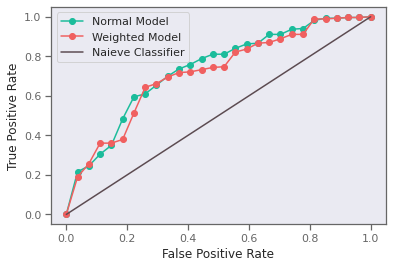

In [23]:
unique_threshes = np.unique(bin_classifier(test_x, w2, b2))
fp = []
tp = []
total_pos = np.sum(test_y)
for ut in list(unique_threshes) + [-0.1, 1.01]:
    errors = error_types(test_y, bin_classifier(test_x, w2, b2), ut)
    fp.append(errors[0])
    tp.append(total_pos - errors[1])

# sort them so can plot as a line
idx = np.argsort(fp) 
fpr = np.array(fp)[idx]  / (len(test_y) - np.sum(test_y))
tpr = np.array(tp)[idx] / np.sum(test_y)

# now remove duplicate x-values
fpr_nd2 = []
tpr_nd2 = []
last = None
for f,t in zip(fpr, tpr):
    if last is None or f != last:
        last = f
        fpr_nd2.append(f)
        tpr_nd2.append(t)

plt.plot(fpr_nd, tpr_nd, '-o', label='Normal Model')
plt.plot(fpr_nd2, tpr_nd2, '-o', label='Weighted Model')
plt.plot([0,1], [0, 1], label='Naieve Classifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

It appears our weighted training actually did not improve model performance, except in a small range between 0.25-0.4 false positive rate. It is even worse in the low false positive rate, which is where we would like to operate. In conclusion, we can modify the balance of false positive and false negative through modifications to training. However, we can also modify this after training by affecting the threshold for classification. This post-training procedure gives similar or even slightly better performance in our example. This may not always be the case!


## Overfitting

The goal of this chapter is to introduce classification. For simplicity, we did not use any of the techniques from the last chapter, except training/testing splitting. You can and should use techniques like Jacknife+ and cross-validation to assess overfitting. Also, our descriptor number was very high, a few hundred, and regularization could be helpful for these models. 

## Chapter Summary

* We introduced classification, which is supervised learning with categorical labels. The labels can be single binary values - representing 2 classes which is binary classification.
* We can compute descriptors for molecules using Python packages and do not require them to be part of our dataset
* Cross-entropy loss should be used for classification tasks
* Classification models (called classifiers) can output distance from decision boundary or, more commonly, probability of class
* The Perceptron is an early example of a neural network classifier that has a special training procedure
* The sigmoid and soft-max functions convert real numbers into probabilities
* Binary classification error can be false positives or false negatives
* Accuracy does not distinguish these two errors, so receive-operator characteristic (ROC) curves can be used to assess model performance. Precision and recall are other commonly used measures. 
* An imbalance of classes in training data is not necessarily a problem and can be addressed by weighting training examples

## Exercises

### Classification

1. Design your own examples of labels for binary, multi-class, and multi-label classification. For example, "A multi-class label is the country a person lives in. A label for this is a 225 element vector with one non-zero element indicating the country the person lives in."

2. Write out the equations for cross-entropy in multi-class and multi-label settings. 

### Data

1. Use the dimensional reduction methods from our [first chapter](./introduction.ipynb) to plot the molecules here in 2D. Color the points based on their lables. Do you see any patterns?

2. Now, wse clustering to color the molecules. Use an elbow plot to choose your cluster number.

### Assessment

1. Repeat the model fitting with L1 and L2 regularization and plot them on a ROC curve. What effect does regularization have on these? Choose a strength of 0.1.

2. Could you use leave-one-class-out cross-validation in binary classification? Why or why not?

3. We said that class imbalance alone has little effect on model training, as long as the testing distribution matches the training distribution. However, can you make an argument using the bias-variance decomposition about why this may not be true with small dataset size?

4. Compute the area under the curve of an ROC curve using numerical trapezoidal integration.

### Complete Model

Do your best to create a binary-classifier for this dataset with regularization and any other methods we learned from this chapter the previous ones. What is the best area under the curve you can achieve?

## Cited References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```